# Lexicality: Language vs Non-Language
A notebook to visualize the classification results of the lexicality problem

Author: Shateesh Bhugwansing

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
%matplotlib inline 


In [3]:
montage = mne.channels.read_montage(kind="ANT_DukeWaveGuard_128_electrode_montages_updated_V4")


In [4]:
# read in data 
epoch_path = '/Volumes/SB/NEW_EPOCH_DATA/20140205_1114_epo.fif'
epoch = mne.read_epochs(epoch_path, preload=True)

Reading /Volumes/SB/NEW_EPOCH_DATA/20140205_1114_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
1908 matching events found
Applying baseline correction (mode: mean)
1908 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [5]:
epoch.drop_channels(['Lm', 'Rm', 'Nasium', 'VEOG'])

<EpochsFIF  |   1908 events (all good), 0 - 0.5 sec, baseline [0, 0], ~467.9 MB, data loaded,
 'b-f1-pic': 60
 'b-f1-snd': 60
 'b-f1-spk': 100
 'b-f1-wrd': 79
 'b-f2-pic': 60
 'b-f2-snd': 60
 'b-f2-spk': 100
 'b-f2-wrd': 79
 'b-tg-pic': 60
 'b-tg-snd': 80
 'b-tg-spk': 79
 'b-tg-wrd': 80
 'f-f1-pic': 100
 'f-f1-snd': 59
 'f-f1-spk': 99
 'f-f1-wrd': 79
 'f-f2-pic': 100
 'f-f2-snd': 59
 'f-f2-spk': 99
 'f-f2-wrd': 79
 'f-tg-pic': 99
 'f-tg-snd': 99
 'f-tg-spk': 79
 'f-tg-wrd': 60>

In [7]:
# remove missing channels 'LL4', 'L12'
epoch.drop_channels(['LL4', 'L12'])


<EpochsFIF  |   1908 events (all good), 0 - 0.5 sec, baseline [0, 0], ~460.5 MB, data loaded,
 'b-f1-pic': 60
 'b-f1-snd': 60
 'b-f1-spk': 100
 'b-f1-wrd': 79
 'b-f2-pic': 60
 'b-f2-snd': 60
 'b-f2-spk': 100
 'b-f2-wrd': 79
 'b-tg-pic': 60
 'b-tg-snd': 80
 'b-tg-spk': 79
 'b-tg-wrd': 80
 'f-f1-pic': 100
 'f-f1-snd': 59
 'f-f1-spk': 99
 'f-f1-wrd': 79
 'f-f2-pic': 100
 'f-f2-snd': 59
 'f-f2-spk': 99
 'f-f2-wrd': 79
 'f-tg-pic': 99
 'f-tg-snd': 99
 'f-tg-spk': 79
 'f-tg-wrd': 60>

In [8]:
len(epoch.ch_names)

123

## Classification experiment (to generate coefficients)
Language vs. Non-Language  
data: NEW_EPOCH_DATA/20140205_1114_epo.fif  
classifier: Logistic regression  
Labels:
* 0 = Language
* 1 = Non Language

In [9]:
# Run Emmanuil's helper notebooks to re-label the data 
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/Artifact_Removal/Batch_ArtifactFilter_Epoch.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../Classification/ConcatEpochTrails.ipynb


ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.
ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.


In [10]:
modality_lexicality_event_ids

{'AALL': 112,
 'AALN': 212,
 'AANL': 312,
 'AANN': 412,
 'AVLL': 512,
 'AVNN': 612,
 'VALL': 712,
 'VANN': 812,
 'VVLL': 912,
 'VVLN': 1012,
 'VVNL': 1112,
 'VVNN': 1212}

In [11]:
new_event_ids = convert_epoch_events_to_stim_combinations(epoch)

In [12]:
epoch.events = new_event_ids

### epoch object has been updated with events that can be used for classification
epoch.events[:,-1] in {112, 312, 512, 712, 912, 1112} = Language  
epoch.events[:,-1] in {212, 412, 612, 812, 1012, 1212} = Non Language 

In [13]:
language = [112, 312, 512, 712, 912, 1112]
non_language = [212, 412, 612, 812, 1012, 1212]

labels = [0 if (x in language) else 1 for x in epoch.events[:,-1]]

In [14]:
labels_np = np.array(labels)

In [15]:
# get imports used for classification algos 

from mne.decoding import Vectorizer, get_coef
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

In [16]:
# perform logistic regression, use cross validation

clf = make_pipeline(
                    Vectorizer(),
#                     MinMaxScaler(),
                    LogisticRegression(C=1))

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)



In [17]:
preds = np.empty(len(epoch._data))
coeff = []
# data = epoch._data

In [50]:
data = epoch._data

In [18]:
for train, test in cv.split(data, labels_np):
    clf.fit(data[train], labels_np[train])
    coeff.append(get_coef(clf,'coef_'))
    preds[test] = clf.predict(data[test])
    
target_names = [ 'Language', 'Non-Language']
report = classification_report(labels, preds, target_names=target_names)
print(report)

              precision    recall  f1-score   support

    Language       0.65      0.67      0.66      1071
Non-Language       0.56      0.54      0.55       837

 avg / total       0.61      0.62      0.61      1908



In [ ]:
# 
# trying this example: https://martinos.org/mne/stable/auto_examples/decoding/plot_linear_model_patterns.html#sphx-glr-auto-examples-decoding-plot-linear-model-patterns-py
# 
# Extract and plot patterns and filters


X = data
y = labels_np

# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
#     StandardScaler(),                   # 2) normalize features across trials
    LogisticRegression(C=1))  # 3) fits a logistic regression
clf.fit(X, y)

coef = get_coef(clf, name, inverse_transform=True)
evoked = EvokedArray(coef, epochs.info, tmin=epochs.tmin)
evoked.plot_topomap(title='EEG %s' % name[:-1], time_unit='s')

In [19]:
from sklearn.model_selection import cross_val_score


In [20]:
scores = cross_val_score(clf, data, labels, cv=10, scoring='accuracy')

In [21]:
scores

array([0.734375  , 0.47120419, 0.64921466, 0.78534031, 0.32984293,
       0.52879581, 0.66492147, 0.33157895, 0.85789474, 0.61578947])

In [22]:
def reshape_coeff_matrix(x, step):
    """
    A method to reshape a 1D list of coefficients into the coefficient matrix: 
    example: (1, 615000) --> (123, 500)
    
    NOTE: YOU NEED TO IMPORT numpy as np to use this method
    
    Arguments: 
    - x = the current, 1D list of coefficients that needs to be reshaped. 
    - step = the desired length of one row in the new matrix (default = 500)
    
    Return:
    - A 2D np array with the desired shape
    """
    reshaped = []
    
    for i in range(0,len(x), step): 
        temp = []
        for j in range(i,i+step):
            temp.append(x[j])
    
        reshaped.append(temp)
    
    return np.array(reshaped)


In [23]:
len(coeff[0][0])

31611

In [24]:
data.shape

(1908, 123, 257)

In [26]:
# Use the helper function to reshape all of the coefficients in coeff
# use the step = 257, want each coefficient matrix in the shape 123x257
coeff_matrices = []

for i in coeff:
    coeff_matrices.append(reshape_coeff_matrix(i[0], 257))

## Ranking the channel + coefficients 
- To do this, I'm going to rank the channels based on the mean of their coefficients over the 500ms period. 
- Do this for each ofthe 10 coefficient matricies that are produced. 
- The hypothesis is that the same channels should appear at the top, meaning they are the same channels being used to do the classification every time (highest coefficients)

In [27]:
coeff_matrices_mean = []

for x in coeff_matrices:
    avg = []
    for i in range(len(x)):
        avg.append(np.mean(x[i]))
    coeff_matrices_mean.append(avg)


    

In [28]:
coeff_matrices_mean_np = np.array(coeff_matrices_mean)

In [29]:
coeff_matrices_mean_np.shape

(10, 123)

In [33]:
channels = epoch.ch_names

In [34]:
# map the means to the channels

coeff_means_channels = []

for x in range(len(coeff_matrices_mean_np)):
    coeff_means_channels.append(dict(zip(channels, coeff_matrices_mean_np[x])))


In [35]:
coeff_means_channels[0]

{'LE1': 0.00012212852027751337,
 'LE3': 1.9579086675459683e-05,
 'LD2': 0.00011389380116126542,
 'LD5': 0.00010714624331361098,
 'LC3': 9.893853819879851e-05,
 'LC6': 3.8849552206186846e-06,
 'LB1': 0.00011471711621153446,
 'LB4': 4.004214053368584e-05,
 'LA2': 6.538288074623115e-05,
 'LA5': -4.5510189763097396e-05,
 'LL1': 0.00011593351028269707,
 'LL7': -4.1757924246961456e-05,
 'LL10': -3.045425314232178e-05,
 'LL13': -0.00012720579135966473,
 'L3': 7.896946904082052e-05,
 'L6': 5.604365091816641e-05,
 'L9': -4.182736895891435e-05,
 'Z1': 0.00011076770982227248,
 'Z4': 5.872504693504361e-05,
 'Z7': -4.800917534941003e-06,
 'Z10': -0.0001084390973810687,
 'Z13': -0.00011885085801885782,
 'R3': 6.66301855104364e-05,
 'R6': 1.7482183472743217e-05,
 'R9': -4.6162541097757884e-05,
 'R12': -0.00013681249530368892,
 'RR1': 6.483566281728567e-05,
 'RR4': 4.695825814991631e-06,
 'RR7': 2.4257038458082003e-05,
 'RR10': -7.823409830967416e-05,
 'RR13': -0.00014062573880353974,
 'RA2': 1.923052

In [36]:
# convert all mean coefficients to abs value 

for d in coeff_means_channels:
    for k in d: 
        d[k] = abs(d[k])

In [37]:
# sort each dictionary in coeff_means_channels in order to rank them. should expect to see the same channels at the top
# for each dict


In [38]:
sorted_means_channels = []

for x in range(len(coeff_means_channels)):
    d = coeff_means_channels[x]
    sorted_means_channels.append(sorted(d, key=d.get, reverse=True))

In [39]:
sorted_means_channels[0]

['STI 014',
 'LD1',
 'RR11',
 'RR12',
 'RR13',
 'LL12',
 'R14',
 'L13',
 'R13',
 'R12',
 'Z14',
 'LC1',
 'LL13',
 'RD7',
 'LE1',
 'R11',
 'L1',
 'Z13',
 'LL2',
 'LE4',
 'LL1',
 'LB1',
 'LC2',
 'LD2',
 'RC6',
 'L11',
 'LD4',
 'Z1',
 'Z10',
 'LB2',
 'R1',
 'L2',
 'LD5',
 'RD6',
 'Z12',
 'LD3',
 'Z11',
 'LC3',
 'RC7',
 'LL3',
 'L14',
 'R10',
 'R2',
 'RB5',
 'LA1',
 'L3',
 'RR10',
 'RA5',
 'Z2',
 'RB6',
 'RD5',
 'Z9',
 'LB3',
 'R3',
 'L5',
 'LA2',
 'RR1',
 'RE1',
 'LC4',
 'LL5',
 'Z4',
 'RR9',
 'L4',
 'LB5',
 'L6',
 'LC7',
 'RR5',
 'LD7',
 'Z3',
 'Z5',
 'R9',
 'LL11',
 'LA5',
 'L10',
 'LB6',
 'RD2',
 'R4',
 'L9',
 'LL7',
 'RE3',
 'LB4',
 'Z8',
 'RE4',
 'LL8',
 'RC1',
 'RA4',
 'LA4',
 'RC5',
 'RD1',
 'RR2',
 'LL6',
 'LC5',
 'L7',
 'RA1',
 'RB1',
 'LL10',
 'R7',
 'RB4',
 'L8',
 'RR3',
 'RR7',
 'R5',
 'LL9',
 'LA3',
 'Z6',
 'LE3',
 'RA2',
 'R6',
 'LD6',
 'RB3',
 'RR8',
 'RC3',
 'RB2',
 'RD3',
 'Z7',
 'RR4',
 'LC6',
 'RD4',
 'RC2',
 'RA3',
 'RR6',
 'R8',
 'RC4']

In [40]:
sorted_means_channels[1]

['STI 014',
 'RR12',
 'RR13',
 'RD7',
 'RC6',
 'RD6',
 'R11',
 'RC7',
 'RR11',
 'LE1',
 'LD2',
 'RB5',
 'R1',
 'Z14',
 'LL12',
 'R14',
 'LD4',
 'L13',
 'R13',
 'R12',
 'LL13',
 'LD5',
 'R2',
 'LC3',
 'RD5',
 'RR10',
 'LB2',
 'LD1',
 'Z10',
 'L11',
 'LD3',
 'Z12',
 'RR1',
 'LB3',
 'Z13',
 'RA5',
 'RB6',
 'LE4',
 'R10',
 'Z1',
 'L1',
 'LC4',
 'Z11',
 'RE3',
 'LB4',
 'LB1',
 'LC2',
 'RC5',
 'L2',
 'LC1',
 'LA4',
 'LL5',
 'RD1',
 'LL2',
 'R3',
 'RE1',
 'LA2',
 'RR9',
 'LC5',
 'RC1',
 'LL1',
 'LA1',
 'L5',
 'LA3',
 'RA4',
 'LC6',
 'Z9',
 'RD2',
 'RB1',
 'L3',
 'Z2',
 'RR5',
 'LL6',
 'L6',
 'LL3',
 'R9',
 'RR2',
 'L7',
 'Z4',
 'RB4',
 'R7',
 'RR3',
 'Z5',
 'L4',
 'LE3',
 'Z3',
 'RA1',
 'Z6',
 'R4',
 'Z8',
 'L14',
 'R6',
 'R5',
 'RR8',
 'RD3',
 'LL7',
 'RA3',
 'RD4',
 'RA2',
 'LD6',
 'RC2',
 'RC4',
 'LB6',
 'LL9',
 'RR7',
 'R8',
 'L9',
 'RE4',
 'RB2',
 'Z7',
 'LL8',
 'RC3',
 'LL11',
 'RR6',
 'L10',
 'RR4',
 'LA5',
 'LB5',
 'LD7',
 'L8',
 'RB3',
 'LC7',
 'LL10']

In [41]:
# take the top 30 ranking channels, based on their mean coefficients, from all 10 iterations of the classification.
# Are the top 30 the same across all 10 iterations?
# note: I took the top 30, because 30 is roughly 25% of 123

top20 = []

for x in sorted_means_channels:
    top20.append(x[:20])

In [42]:
top20_np = np.array(top20)

In [43]:
top20_np.shape

(10, 20)

In [44]:
top20_flat = top20_np.flatten()

In [51]:
from collections import Counter

counts = Counter(top20_flat)

In [52]:
counts

Counter({'STI 014': 10,
         'LD1': 9,
         'RR11': 10,
         'RR12': 10,
         'RR13': 10,
         'LL12': 9,
         'R14': 9,
         'L13': 8,
         'R13': 8,
         'R12': 9,
         'Z14': 9,
         'LC1': 2,
         'LL13': 7,
         'RD7': 10,
         'LE1': 5,
         'R11': 9,
         'L1': 2,
         'Z13': 4,
         'LL2': 2,
         'LE4': 3,
         'RC6': 9,
         'RD6': 9,
         'RC7': 8,
         'LD2': 4,
         'RB5': 4,
         'R1': 6,
         'LD4': 3,
         'L14': 1,
         'R2': 2,
         'Z1': 4,
         'LE3': 1,
         'Z10': 1,
         'L2': 1,
         'LL1': 1,
         'RR10': 1})

In [53]:
counts.pop('STI 014')

10

In [54]:
len(counts.keys())

34

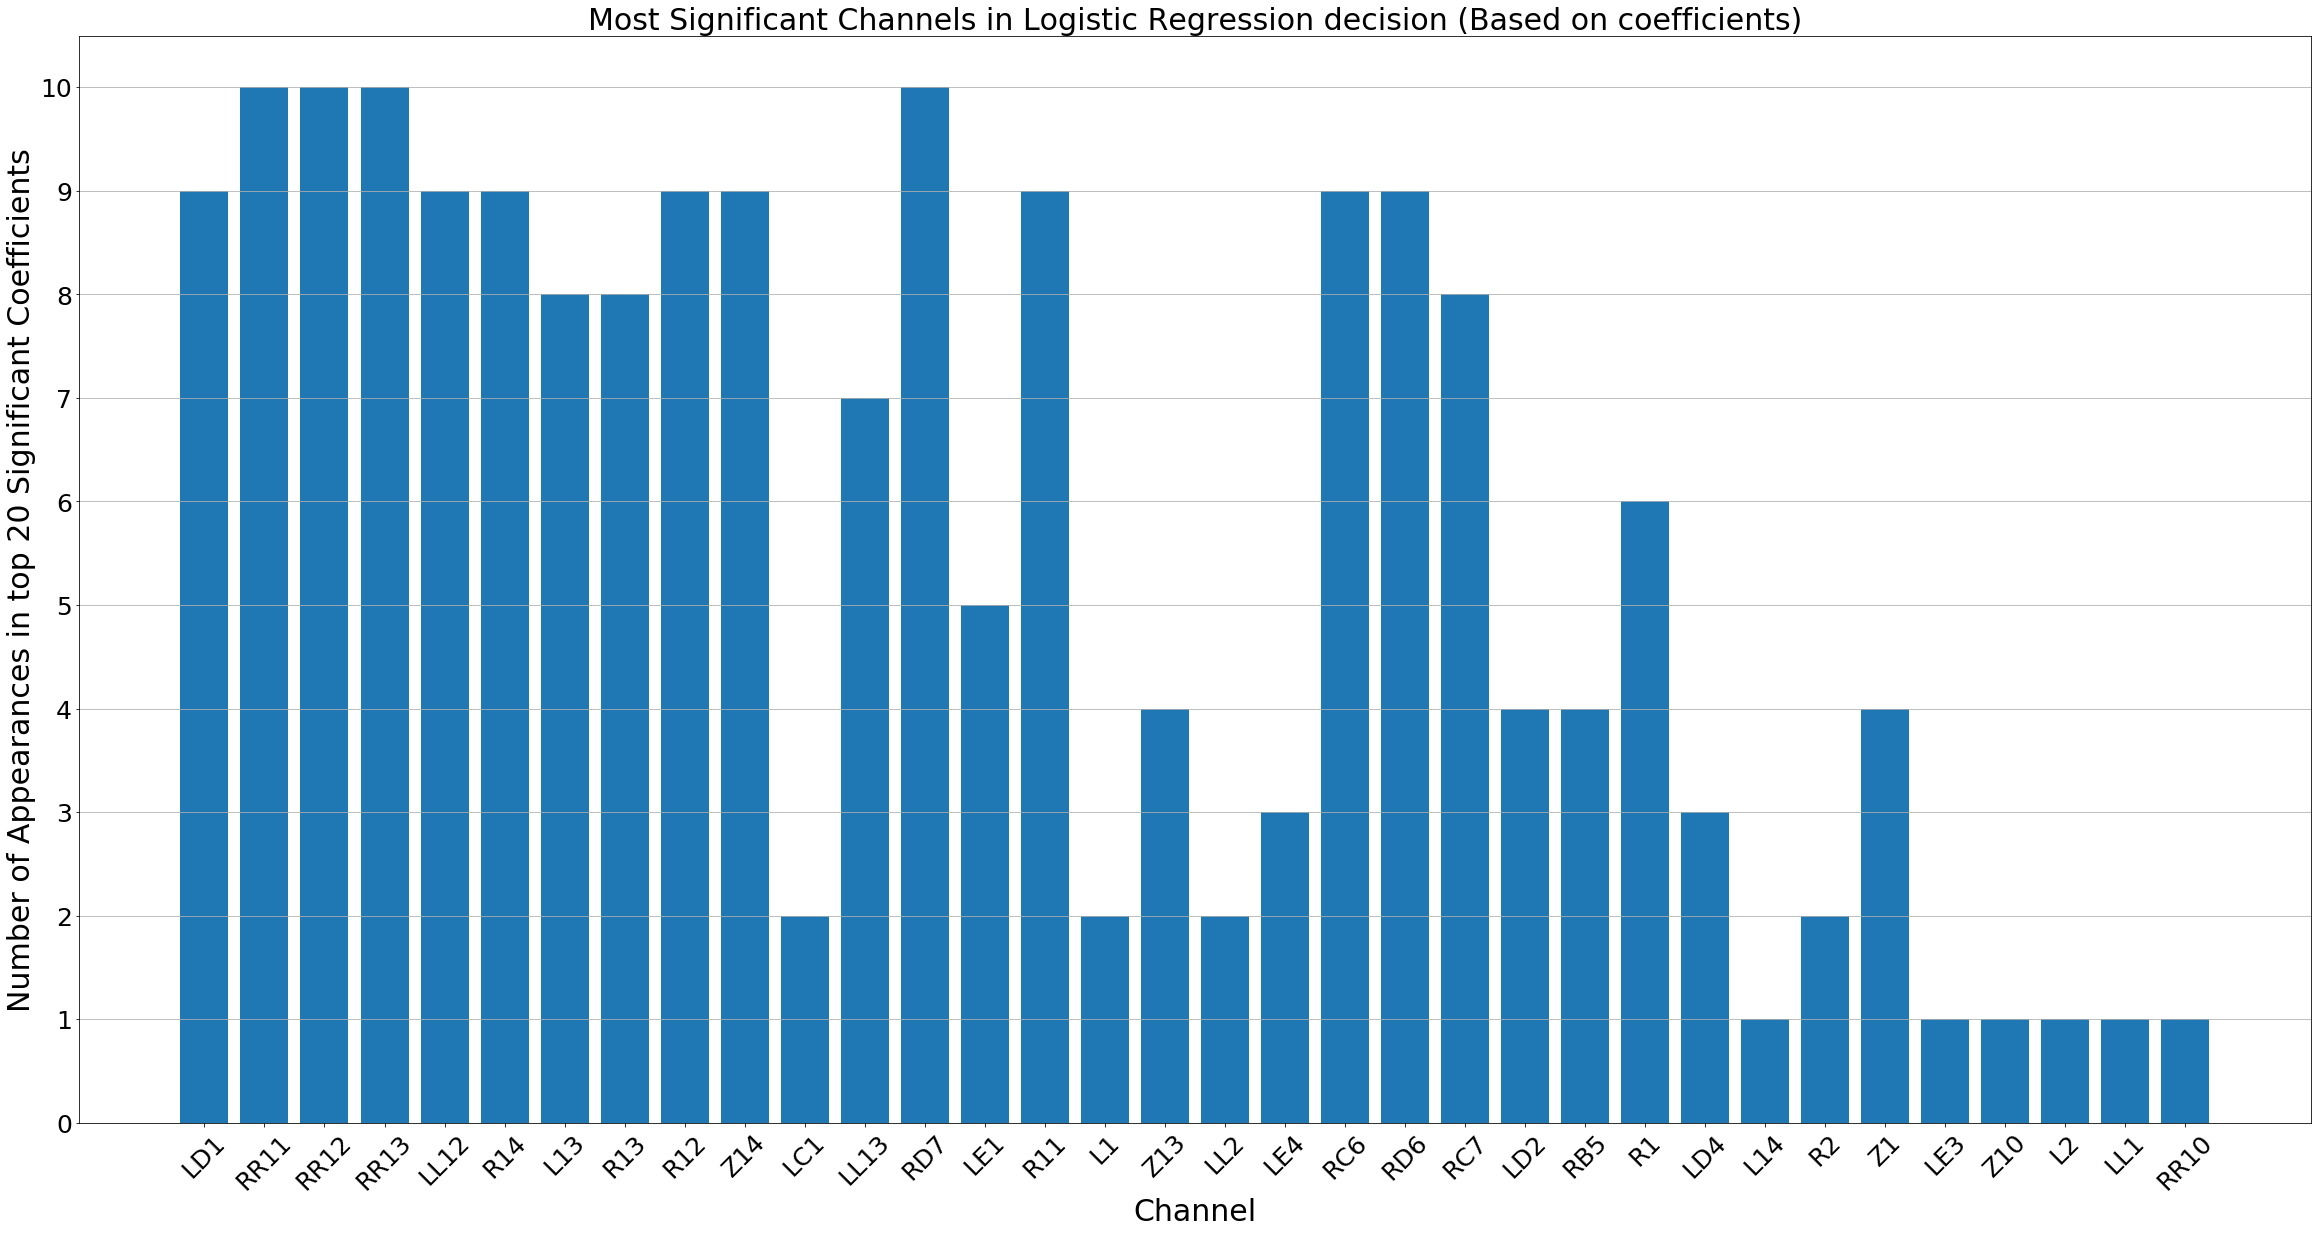

In [56]:
fig, ax = plt.subplots()

plt.bar(counts.keys(), counts.values())
ax.set_ylabel("Number of Appearances in top 20 Significant Coefficients", fontsize=30)
ax.set_xlabel("Channel", fontsize=30)
ax.set_title("Most Significant Channels in Logistic Regression decision (Based on coefficients)", fontsize=30)
ax.grid(True, axis='y')
plt.xticks(np.arange(0, len(counts.keys())), counts.keys(), rotation=45, fontsize=25);
plt.yticks(np.arange(0,11,step=1), fontsize=25 )
fig.set_figwidth(40)
fig.set_figheight(20)


matplotlib.rcParams.update({'font.size': 15})

In [57]:
# check the variance amongst the mean coefficients for all 10 iterations 

for i in range(len(coeff_means_channels)):
    d = coeff_means_channels[i]
    values = list(d.values())
    print("Fold ", i, ": ", np.var(values))
    

Fold  0 :  3.116720116600012e-08
Fold  1 :  5.7635841752869055e-08
Fold  2 :  1.4979001061786903e-08
Fold  3 :  2.54062144044129e-08
Fold  4 :  3.134820946987208e-08
Fold  5 :  1.9406973086019175e-08
Fold  6 :  2.0445352237518327e-08
Fold  7 :  1.5616479321148673e-09
Fold  8 :  7.30604505210112e-08
Fold  9 :  6.309115818743654e-08


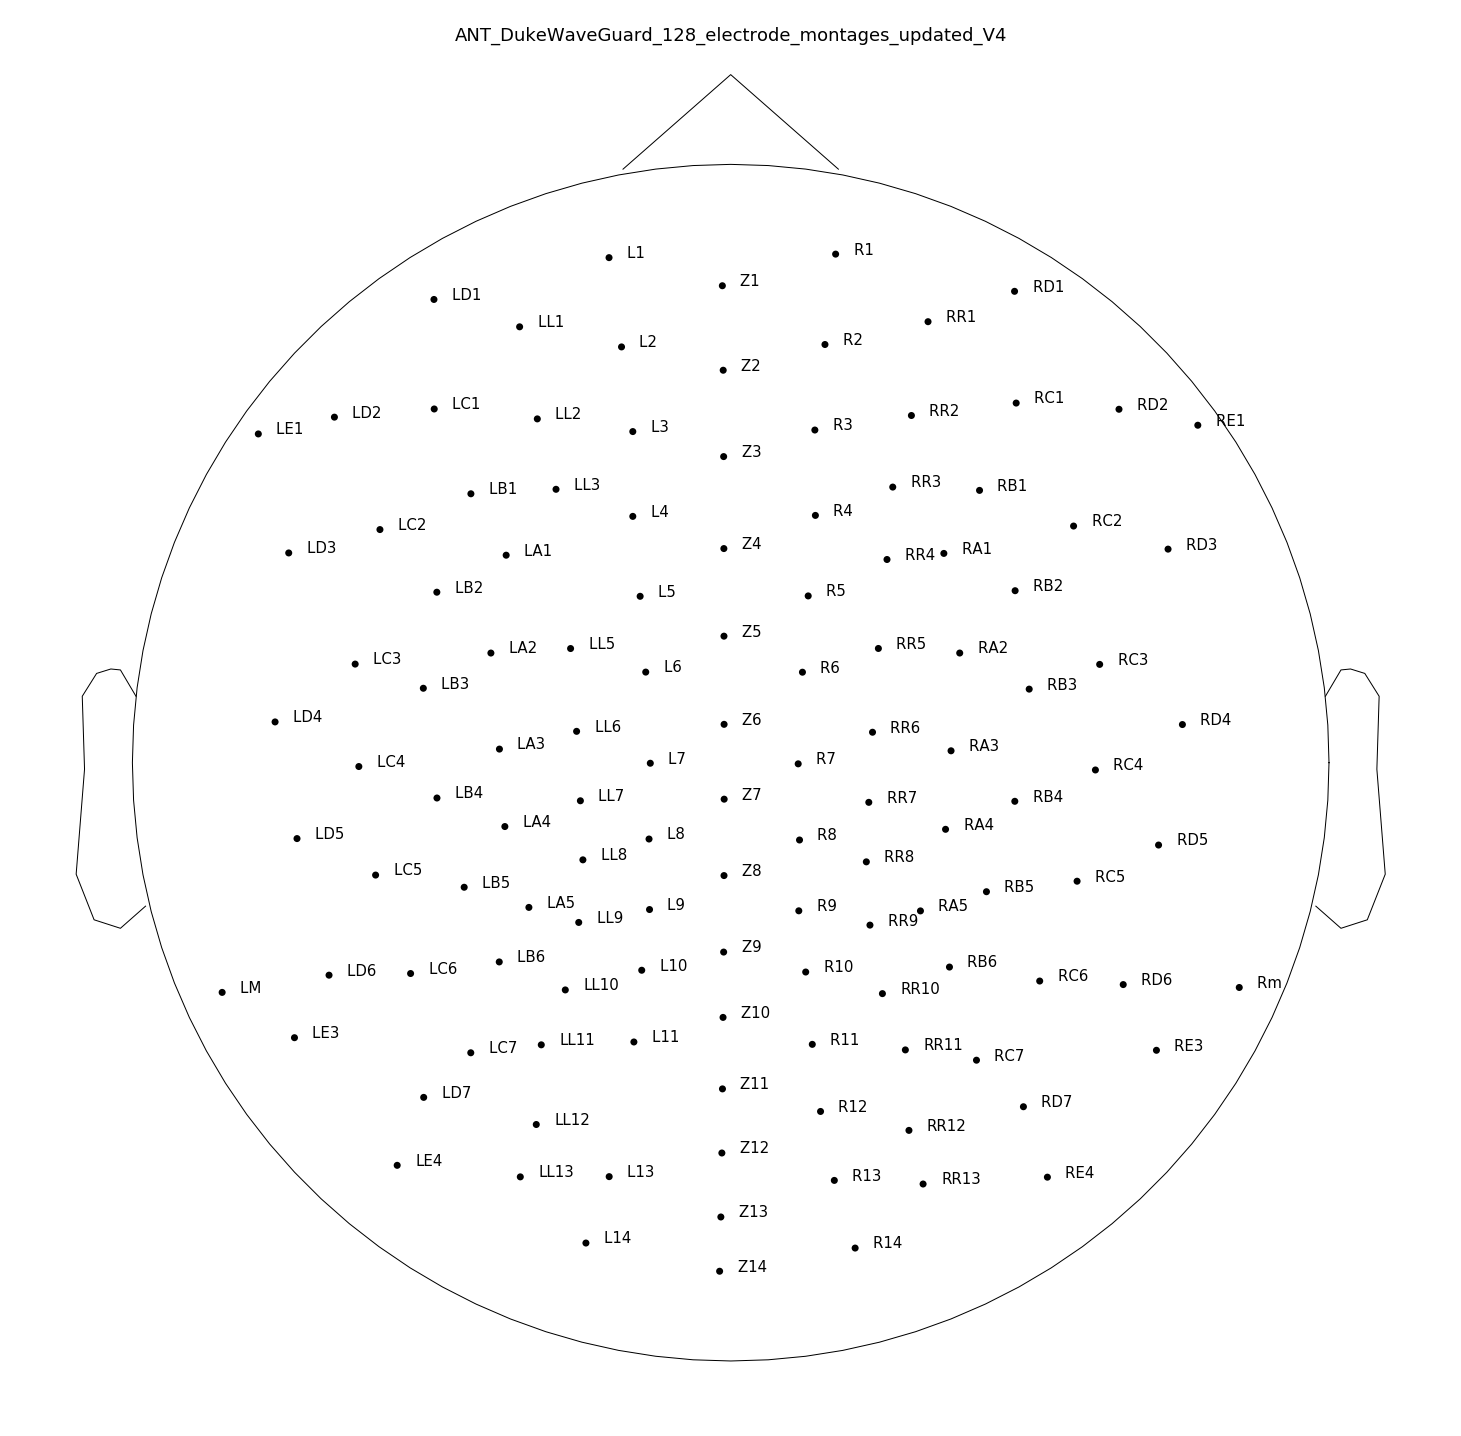

In [60]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
montage.plot(); 

matplotlib.rcParams.update({'font.size': 18})